In [1]:
#experiment name and snapshot folder (used for model persistence)
experiment_setup_name = "research.rl_comparison.naive"
snapshot_path = "/home/jheuristic/yozhik/agentnet_snapshots/"

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


#theano imports
#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'
import theano
import theano.tensor as T
floatX = theano.config.floatX

import lasagne


env: THEANO_FLAGS='device=cpu'


/home/jheuristic/thenv/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [3]:
%load_ext autoreload
%autoreload 2

# This tutorial vuilds above the basic tutorial and shows several advanced tools
* multi-layer (and in principle, arbitrary) agent memory
* different reinforcement learning algorithms
* model persistence

__[todo: add more]__


# Experiment setup
* Here we load an experiment environment (description below)
* Designing one from scratch is explained in later tutorials

In [4]:
import agentnet.experiments.wikicat as experiment
print experiment.__doc__


This experiment Wikipedia data sample on musicians, scraped via the scripts present in this directory. 
For each musician, we know a number of boolean features (factors) on various topics like 
 * whether or not he/she was active in 1990's, 2000's, etc.
 * whether or not he/she plays guitar, piano, etc
 * whether or not he/she was born in 50's, 60's, etc.
 * what wikipedia categories does he/she belong to
 etc.



In the initial moment of time, agent knows nothing about any of them.
At each turn, agent may decide to
 - "open" one of the hidden factors.
   - if the factor turns out to be 1, agent receives +3 reward for Wikipedia categories, +1 for other categories,
   - Otherwise, the reward equals -1 for Wikipedia categories, -1 for other categores
   - all these rewards are parameterisable during environment creation
 - decide to quit session
   - yields reward of 0 and ends the interaction.
   - all farther actions will have no effect until next session

It is expected, that in orde

In [5]:
#Create an environment with all default parameters
env = experiment.WikicatEnvironment()

In [6]:
from sklearn.cross_validation import train_test_split
attrs, categories, feature_names = env.get_dataset()

train_attrs,test_attrs,train_cats,test_cats = train_test_split(attrs,categories,test_size=0.99,random_state=32)

print "train size:", train_attrs.shape,train_cats.shape
print "train size:", test_attrs.shape,test_cats.shape

print "features:",feature_names[::20]

train size: (85, 300) (85, 93)
train size: (8509, 300) (8509, 93)
features: ['Children:is_known', 'Instruments:vocals', 'Genres:electronic', 'Origin:scotland', 'Genres:jazz', 'Genres:electric', 'Occupation:bassist', 'Instruments:violin', 'Genres:instrumental', 'Occupation:entrepreneur', 'Instruments:mandolin', 'Instruments:vocalist', 'Genres:synthpop', 'decades_active:1990', 'Occupation:remixer', 'category:List_of_musical_artists_from_Japan', 'category:List_of_ambient_music_artists', 'category:List_of_crooners', 'category:List_of_country_music_performers', 'category:List_of_bass_guitarists']


In [7]:
env.load_random_batch(train_attrs,train_cats,5)

# agent setup
* An agent implementation has to contain three parts:
 * Memory layer(s)
  * in this case, we train two GRU layers [details below]
 * Q-values evaluation layers
  * in this case, a lasagne dense layer based on memory layer
 * Resolver - acton picker layer
  * in this case, the resolver has epsilon-greedy policy
  
  
### two-layer memory architecture
We train two memory states:
  * first one, based on observations,
  * second one, based on first one;

Note that here we update the second memory layer based on the CURRENT state
of the first one. Instead, you can try to feed it with a previous state.

The q-values are estimated on a concatenated state, effectively on both memory
states together, but there is no problem with limiting q-evaluator to only one:
just pass the correct gru layer as an incoming layer to the q-evaluator.

### Implementation:
We concatenate both memories into 1 state to pass it through the session loop.

To perform memory update, we need to slice the concatenated state back into
two memory states.

We do so by defining an input map function and passing it into agent.

We than concatenate two new states back to form a new memory state.



In [8]:
from agentnet.resolver import EpsilonGreedyResolver
from agentnet.memory import GRUMemoryLayer
from agentnet.agent import Agent

In [9]:
import lasagne
n_hid_1=128 #first GRU memory
n_hid_2=64 #second GRU memory


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")

_prev_gru1_layer = lasagne.layers.InputLayer([None,n_hid_1],name="prev_gru1_state_input")
_prev_gru2_layer = lasagne.layers.InputLayer([None,n_hid_2],name="prev_gru2_state_input")

#memory
gru1 = GRUMemoryLayer(n_hid_1,
                     _observation_layer,
                     _prev_gru1_layer,
                     name="gru1")

gru2 = GRUMemoryLayer(n_hid_2,
                     gru1,        #note that it takes CURRENT gru1 output as input.
                                  #replacing that with _prev_gru1_state would imply taking previous one.
                     _prev_gru2_layer,
                     name="gru2")

concatenated_memory = lasagne.layers.concat([gru1,gru2])

#q_eval
n_actions = len(feature_names)
q_eval = lasagne.layers.DenseLayer(concatenated_memory, #taking both memories. 
                                                        #Replacing with gru1 or gru2 would mean taking one
                                   num_units = n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")
#resolver
epsilon = theano.shared(np.float32(0.9),"e-greedy.epsilon")

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")



#we need to define the new input map because concatenated_memory is a ConcatLayer and does not have default one

def custom_input_map(last_hidden,observation):
    """just a function that maps memory states to respective inputs"""
    return {
        _prev_gru1_layer:last_hidden[:,0:n_hid_1],
        _prev_gru2_layer:last_hidden[:,n_hid_1:n_hid_1+n_hid_2],
        _observation_layer:observation
    }

#all together
agent = Agent(concatenated_memory,q_eval,resolver,input_map=custom_input_map
             )


In [10]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru1.W_in_to_updategate,
 gru1.W_hid_to_updategate,
 gru1.b_updategate,
 gru1.W_in_to_resetgate,
 gru1.W_hid_to_resetgate,
 gru1.b_resetgate,
 gru1.W_in_to_hidden_update,
 gru1.W_hid_to_hidden_update,
 gru1.b_hidden_update,
 gru2.W_in_to_updategate,
 gru2.W_hid_to_updategate,
 gru2.b_updategate,
 gru2.W_in_to_resetgate,
 gru2.W_hid_to_resetgate,
 gru2.b_resetgate,
 gru2.W_in_to_hidden_update,
 gru2.W_hid_to_hidden_update,
 gru2.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

## Agent setup in detail
* __Memory layers__
 * One-step recurrent layer
     * takes input and one's previous state
     * returns new memory state
   * Can be arbitrary lasagne layer
   * Several one-step recurrent units are implemented in __agentnet.memory__
   * Note that lasagne's default recurrent networks roll for several steps at once
     * in other words, __using lasagne recurrent units as memory means recurrence inside recurrence__
 * Using more than one memory layer is explained in farther tutorials


* __Q-values evaluation layer__
 * Can be arbitrary lasagne network
 * returns predicted Q-values for each action
 * Usually depends on memory as an input


* __Resolver__ - action picker
 * Decides on what action is taken
 * Normally takes Q-values as input
 * Currently all experiments require integer output
 * Several resolver layers are implemented in __agentnet.resolver__

# Interacting with environment
* an agent has a method that produces symbolic environment interaction sessions
* interactions result in sequences of observations, actions, q-values,etc
* one has to pre-define maximum session length.
 * in this case, environment implements an indicator of whether session has ended by current tick
* Since this environment also implements Objective methods, it can evaluate rewards for each [batch, time_tick]


In [11]:
#produce interaction sequences of length <= 10
history = agent.get_sessions(env,session_length=10,
                       batch_size=env.batch_size,)

state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

#get rewards for all actions
rewards_seq = env.get_reward_sequences(state_seq,action_seq)

#get indicator whether session is still active
is_alive_seq = env.get_whether_alive(observation_seq)


In [12]:

#Let us compile a function that returns all interaction logs
get_history = theano.function([],history+(is_alive_seq,rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# Evaluating loss function
* This part is similar to the basic tutorial but for the fact that we use SARSA
 
 
 #### Get (prediction,reference) pairs

In [15]:
#get reference Qvalues according to Qlearning algorithm


from agentnet.learning import n_step


#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = theano.shared(np.float32(0.95),name = 'q_learning_gamma')


reference_Qvalues = n_step.get_reference(
    qvalues_seq,action_seq,rewards_seq,
    is_alive= is_alive_seq,
    gamma_or_gammas=gamma,
)

In [17]:
#zero-out future rewards at session end
from agentnet.utils.mdp import get_end_indicator

end_action_ids = get_end_indicator(is_alive_seq).nonzero()

# "set reference Qvalues at end action ids to just the immediate rewards"
reference_Qvalues = T.set_subtensor(reference_Qvalues[end_action_ids],
                                    rewards_seq[end_action_ids])

In [18]:
#prevent gradient updates over reference Qvalues (since they depend on predicted Qvalues)
from agentnet.utils import consider_constant
reference_Qvalues = consider_constant(reference_Qvalues)

In [19]:
from agentnet.utils.mdp import get_action_Qvalues
action_Qvalues = get_action_Qvalues(qvalues_seq,action_seq)

#### Define loss functions

In [20]:
#tensor of elementwise squared errors
squared_error = lasagne.objectives.squared_error(reference_Qvalues,action_Qvalues)

#zero-out ticks after session ended
squared_error = squared_error * is_alive_seq

#compute average of squared error sums per session
mse_loss = squared_error.sum() / is_alive_seq.sum()

In [21]:
#regularize network weights

from lasagne.regularization import regularize_network_params, l2
reg_l2 = regularize_network_params(resolver,l2)*10**-4

In [22]:
loss = mse_loss + reg_l2

#### Compute weight updates

In [23]:

updates = lasagne.updates.adadelta(loss,
                                             weights,learning_rate=0.05)

#### Some auxilary evaluation metrics

In [24]:
mean_session_reward = rewards_seq.sum(axis=1).mean()
#...

# Compile train and evaluation functions

In [25]:
train_fun = theano.function([],[loss,mean_session_reward],updates=updates)

evaluation_fun = theano.function([],[loss,mse_loss,reg_l2,mean_session_reward])

# session visualization tools


* this is a completely optional step of visualizing agent's sessions as chains of actions
* usually useful to get insight on what worked and what din't
* in this case, we print strings following pattern
  * [action_name] ([predicted action qvalue]) -> reward [reference qvalue] | next iteration

* plot shows
    * time ticks over X, abstract values over Y
    * bold lines are Qvalues for actions
    * dots on bold lines represent what actions were taken at each moment of time
    * dashed lines are agent's hidden state neurons
    * blue vertical line - session end
    
    
__Warning! the visualization tools are underdeveloped and only allow simple operations.__

if you found yourself struggling to make it do what you want for 5 minutes, go write your own tool [and contribute it :)]


In [26]:
from agentnet.display.sessions import print_sessions
get_printables = theano.function([], [
        hidden_seq,qvalues_seq, action_seq,rewards_seq,reference_Qvalues,is_alive_seq
    ])

def display_sessions(with_plots = False):
        
    hidden_log,qvalues_log,actions_log,reward_log, reference_qv_log, is_alive_log = get_printables()
    
    
    print_sessions(qvalues_log,actions_log,reward_log,
                   is_alive_seq = is_alive_log,
                   #hidden_seq=hidden_log, #do not plot hidden since there's too many actions already
                   reference_qvalues_seq = reference_qv_log,
                   action_names=feature_names,
                   legend = False, #do not show legend since there's too many labeled objects
                  plot_qvalues = with_plots)

session # 0
 Genres:heavy(qv = 0.0) -> -1.0(ref = -7.39501094818) |  Occupation:bandleader(qv = -0.00413972232491) -> -1.0(ref = -6.73159074783) |  Political party:is_known(qv = 0.0214340761304) -> -1.0(ref = -6.03325366974) |  Label(s):is_known(qv = 0.0284324251115) -> -1.0(ref = -5.29816198349) |  category:List_of_jazz_trumpeters(qv = 0.128547996283) -> -1.0(ref = -4.52438116074) |  category:List_of_gospel_musicians(qv = 0.0557077527046) -> -1.0(ref = -3.70987486839) |  Genres:contemporary(qv = -0.0398572087288) -> -1.0(ref = -2.85249996185) |  last_activity:still_active(qv = 0.125608250499) -> -1.0(ref = -1.95000004768) |  last_activity:1989(qv = -0.00494349747896) -> -1.0(ref = -1.0) |  category:List_of_lead_guitarists(qv = -0.0249271001667) -> 0.0(ref = 0.0) | reached max session length


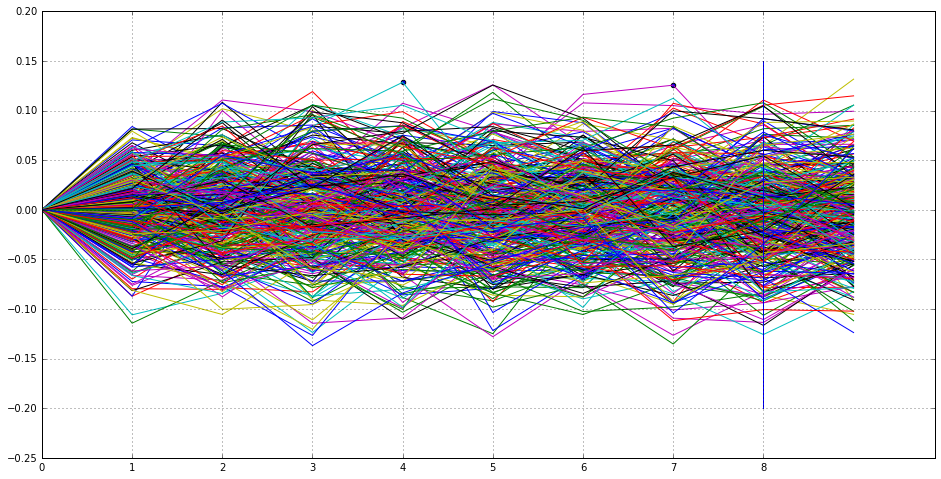

In [27]:
#visualize untrained network performance (which is mostly random)
env.load_random_batch(train_attrs,train_cats,1)
display_sessions(with_plots=True)

# Training loop

In [28]:
#tools for model persistence
from agentnet.utils.persistence import save,load
import os

In [29]:
from agentnet.display import Metrics
score_log = Metrics()

In [ ]:
#starting epoch
epoch_counter = 1

#moving average estimation
alpha = 0.1
ma_reward_current = -7.
ma_reward_greedy = -7.

epoch 100,loss 17.47027, epsilon 0.99055, rewards: ( e-greedy -7.08400, greedy -6.95100) 
rec 17.207 reg 0.263
epoch 200,loss 16.24850, epsilon 0.98119, rewards: ( e-greedy -7.13460, greedy -6.86590) 
rec 15.985 reg 0.263
epoch 300,loss 12.58100, epsilon 0.97192, rewards: ( e-greedy -7.15614, greedy -6.17931) 
rec 12.316 reg 0.265
epoch 400,loss 8.62214, epsilon 0.96275, rewards: ( e-greedy -7.08053, greedy -5.56138) 
rec 8.355 reg 0.267
epoch 500,loss 7.29827, epsilon 0.95367, rewards: ( e-greedy -7.02247, greedy -5.00524) 
rec 7.029 reg 0.269
epoch 600,loss 5.45762, epsilon 0.94468, rewards: ( e-greedy -6.88923, greedy -4.50472) 
rec 5.187 reg 0.271
epoch 700,loss 4.28880, epsilon 0.93577, rewards: ( e-greedy -6.78130, greedy -4.05425) 
rec 4.016 reg 0.273
epoch 800,loss 3.65903, epsilon 0.92696, rewards: ( e-greedy -6.64217, greedy -3.64882) 
rec 3.385 reg 0.274
epoch 900,loss 3.39778, epsilon 0.91823, rewards: ( e-greedy -6.53596, greedy -3.28394) 
rec 3.123 reg 0.275
epoch 1000,lo

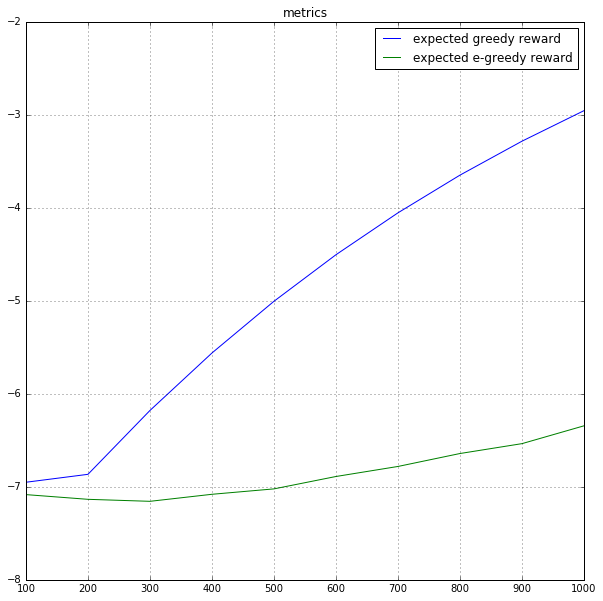

Random session examples
session # 0
 Origin:atlanta(qv = -2.47410964966) -> -1.0(ref = -5.68026161194) |  category:List_of_jazz_trumpeters(qv = -4.04080915451) -> -1.0(ref = -4.92659139633) |  category:List_of_girl_groups(qv = -4.20458936691) -> -1.0(ref = -4.13325405121) |  Genres:blues(qv = -4.03138208389) -> 1.0(ref = -3.29816198349) |  Occupation:educator(qv = -3.50199007988) -> -1.0(ref = -4.52438116074) |  Genres:score(qv = -2.77795934677) -> -1.0(ref = -3.70987486839) |  Genres:roll(qv = -2.27631282806) -> -1.0(ref = -2.85249996185) |  Genres:chicago(qv = -1.95564973354) -> -1.0(ref = -1.95000004768) |  Origin:sweden(qv = -0.792163491249) -> -1.0(ref = -1.0) |  category:List_of_pop_and_rock_pianists(qv = 0.219005689025) -> 0.0(ref = 0.0) | reached max session length
session # 1
 Genres:gangsta(qv = -2.54103970528) -> -1.0(ref = -6.06817054749) |  decades_active:1970(qv = -2.91988968849) -> -1.0(ref = -5.33491659164) |  Genres:soul(qv = -3.95337510109) -> -1.0(ref = -4.5630702972

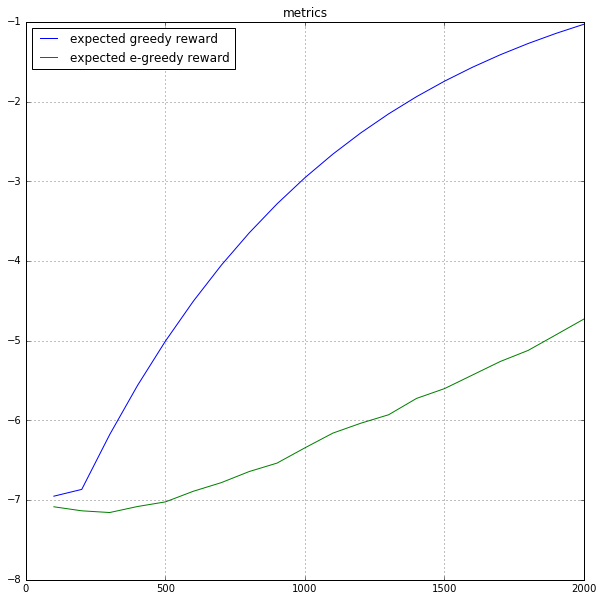

Random session examples
session # 0
 category:List_of_adult_alternative_artists(qv = -3.12840294838) -> -1.0(ref = -3.70987486839) |  category:List_of_child_music_prodigies(qv = -3.59584116936) -> -1.0(ref = -2.85249996185) |  first_activity:1959(qv = -3.7809150219) -> -1.0(ref = -1.95000004768) |  category:List_of_country_music_performers(qv = -3.13275790215) -> -1.0(ref = -1.0) |  end_session_now(qv = -0.0160141456872) -> 0.0(ref = 0.0) | 

session # 1
 end_session_now(qv = -0.00190673209727) -> 0.0(ref = 0.0) | 

session # 2
 category:List_of_smooth_jazz_musicians(qv = -3.43449425697) -> -1.0(ref = -1.0) |  end_session_now(qv = 0.00717846117914) -> 0.0(ref = 0.0) | 

epoch 2100,loss 2.79182, epsilon 0.82006, rewards: ( e-greedy -4.56271, greedy -0.92748) 
rec 2.518 reg 0.274
epoch 2200,loss 2.62451, epsilon 0.81239, rewards: ( e-greedy -4.46444, greedy -0.83473) 
rec 2.351 reg 0.273
epoch 2300,loss 2.85414, epsilon 0.80481, rewards: ( e-greedy -4.33600, greedy -0.75126) 
rec 2.581 r

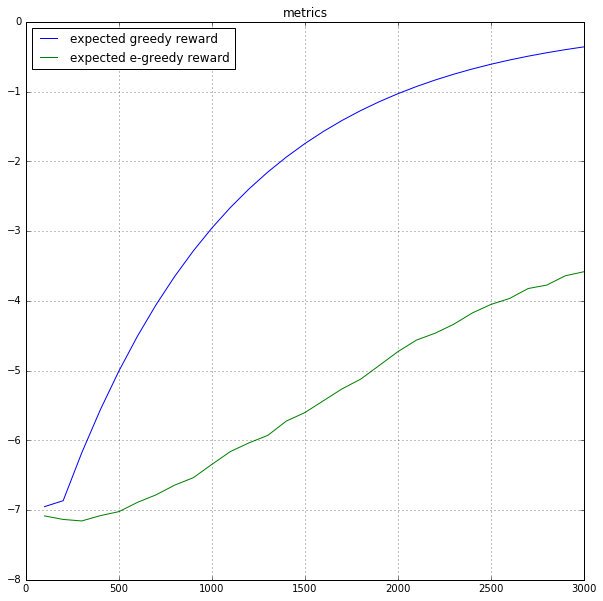

Random session examples
session # 0
 category:List_of_alternative_rock_artists(qv = -3.18251824379) -> -1.0(ref = -4.52438116074) |  Genres:chicago(qv = -3.41687965393) -> -1.0(ref = -3.70987486839) |  category:List_of_Indian_playback_singers(qv = -2.65845918655) -> -1.0(ref = -2.85249996185) |  Instruments:cello(qv = -2.48585391045) -> -1.0(ref = -1.95000004768) |  last_activity:2001(qv = -2.3717238903) -> -1.0(ref = -1.0) |  end_session_now(qv = 0.0152233783156) -> 0.0(ref = 0.0) | 

session # 1
 end_session_now(qv = 0.00258995033801) -> 0.0(ref = 0.0) | 

session # 2
 category:List_of_saxophonists(qv = -3.07596755028) -> -1.0(ref = -2.85249996185) |  Instruments:voice(qv = -3.15986013412) -> -1.0(ref = -1.95000004768) |  Home town:is_known(qv = -2.58760881424) -> -1.0(ref = -1.0) |  end_session_now(qv = 0.00296992994845) -> 0.0(ref = 0.0) | 

epoch 3100,loss 2.40706, epsilon 0.74677, rewards: ( e-greedy -3.40278, greedy -0.32339) 
rec 2.138 reg 0.269
epoch 3200,loss 2.30866, epsilon

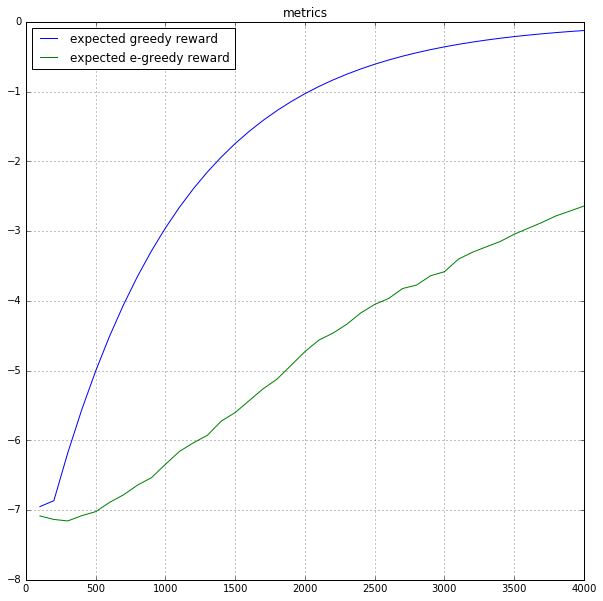

Random session examples
session # 0
 end_session_now(qv = -0.00896378234029) -> 0.0(ref = 0.0) | 

session # 1
 Genres:hardcore(qv = -2.76457262039) -> -1.0(ref = -2.85249996185) |  Occupation:presenter(qv = -2.83688282967) -> -1.0(ref = -1.95000004768) |  Occupation:model(qv = -2.149518013) -> -1.0(ref = -1.0) |  end_session_now(qv = 0.00368024036288) -> 0.0(ref = 0.0) | 

session # 2
 Instruments:drum(qv = -2.5278570652) -> -1.0(ref = -1.0) |  end_session_now(qv = 0.0121263973415) -> 0.0(ref = 0.0) | 

epoch 4100,loss 2.61396, epsilon 0.68047, rewards: ( e-greedy -2.54157, greedy -0.11276) 
rec 2.351 reg 0.263
epoch 4200,loss 1.37911, epsilon 0.67419, rewards: ( e-greedy -2.41541, greedy -0.10148) 
rec 1.117 reg 0.262
epoch 4300,loss 1.47818, epsilon 0.66798, rewards: ( e-greedy -2.33987, greedy -0.09134) 
rec 1.217 reg 0.262
epoch 4400,loss 1.62812, epsilon 0.66183, rewards: ( e-greedy -2.25088, greedy -0.08220) 
rec 1.367 reg 0.261
epoch 4500,loss 1.94462, epsilon 0.65575, rewards:

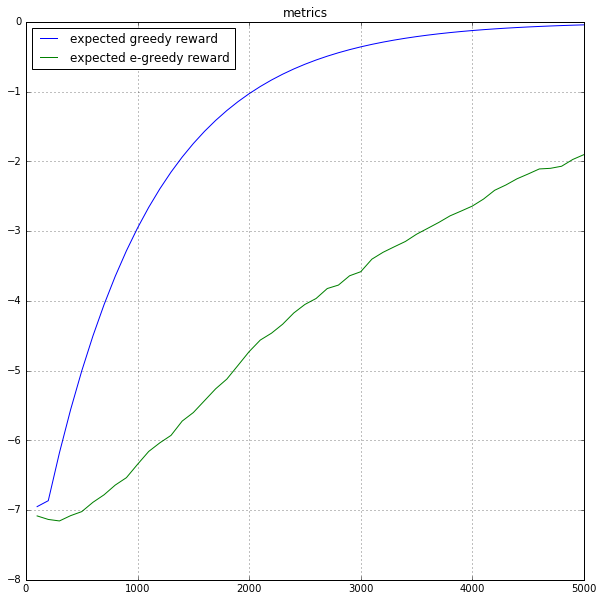

Random session examples
session # 0
 Genres:ambient(qv = -2.36350512505) -> -1.0(ref = -4.52438116074) |  Occupation:activist(qv = -2.24452280998) -> -1.0(ref = -3.70987486839) |  Labels:is_known(qv = -0.448958158493) -> -1.0(ref = -2.85249996185) |  category:List_of_adult_alternative_artists(qv = -1.81597721577) -> -1.0(ref = -1.95000004768) |  Instruments:trumpet(qv = -1.87764430046) -> -1.0(ref = -1.0) |  end_session_now(qv = -0.00556613691151) -> 0.0(ref = 0.0) | 

session # 1
 Genres:r&b(qv = -1.98256993294) -> -1.0(ref = -1.0) |  end_session_now(qv = -0.0104222912341) -> 0.0(ref = 0.0) | 

session # 2
 Occupation:conductor(qv = -2.23747158051) -> -1.0(ref = -5.99833679199) |  Instruments:accordion(qv = -2.30221676826) -> -1.0(ref = -5.26140737534) |  Genres:adult(qv = -2.16223502159) -> -1.0(ref = -4.48569202423) |  Genres:bop(qv = -1.97105371952) -> -1.0(ref = -3.66914963722) |  first_activity:1959(qv = -1.85372543335) -> -1.0(ref = -2.80963134766) |  last_activity:2004(qv = -1.

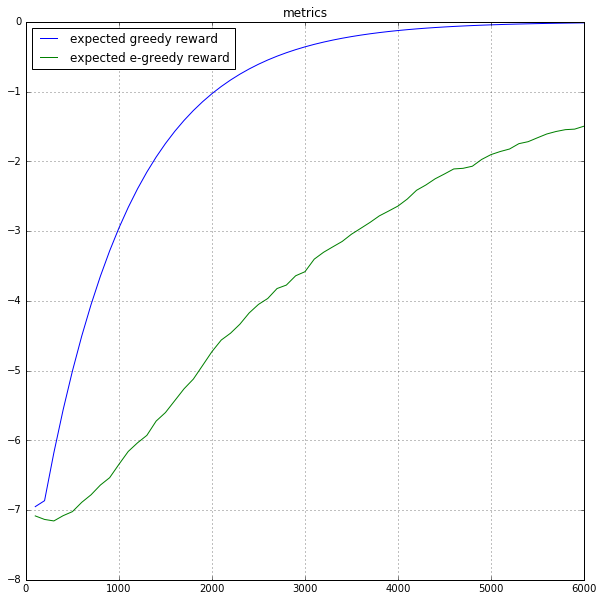

Random session examples
session # 0
 first_activity:1965(qv = -2.14811468124) -> -1.0(ref = -1.0) |  end_session_now(qv = 0.00704240985215) -> 0.0(ref = 0.0) | 

session # 1
 end_session_now(qv = 0.00218621082604) -> 0.0(ref = 0.0) | 

session # 2
 Genres:progressive(qv = -1.8361209631) -> -1.0(ref = -3.70987486839) |  category:List_of_rhythm_guitarists(qv = -1.86047589779) -> -1.0(ref = -2.85249996185) |  first_activity:1998(qv = -1.79436230659) -> -1.0(ref = -1.95000004768) |  category:List_of_jazz_drummers(qv = -1.58170711994) -> -1.0(ref = -1.0) |  end_session_now(qv = -0.00247981958091) -> 0.0(ref = 0.0) | 

epoch 6100,loss 1.15062, epsilon 0.56618, rewards: ( e-greedy -1.43320, greedy -0.01371) 
rec 0.899 reg 0.252
epoch 6200,loss 1.18889, epsilon 0.56105, rewards: ( e-greedy -1.43988, greedy -0.01234) 
rec 0.937 reg 0.252
epoch 6300,loss 1.20415, epsilon 0.55596, rewards: ( e-greedy -1.42689, greedy -0.01110) 
rec 0.953 reg 0.251
epoch 6400,loss 1.31375, epsilon 0.55093, rewards

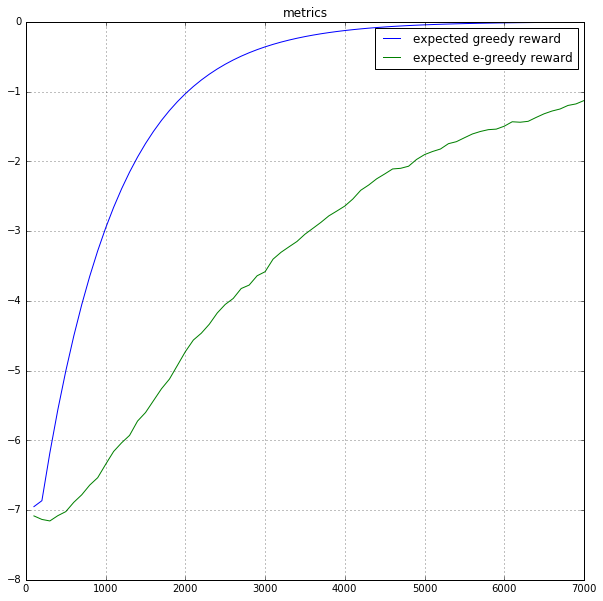

Random session examples
session # 0
 end_session_now(qv = -0.00127839483321) -> 0.0(ref = 0.0) | 

session # 1
 end_session_now(qv = -0.00127839483321) -> 0.0(ref = 0.0) | 

session # 2
 end_session_now(qv = -0.00127840973437) -> 0.0(ref = 0.0) | 

epoch 7100,loss 1.00387, epsilon 0.51706, rewards: ( e-greedy -1.08662, greedy -0.00478) 
rec 0.757 reg 0.247
epoch 7200,loss 0.81768, epsilon 0.51241, rewards: ( e-greedy -1.06996, greedy -0.00430) 
rec 0.571 reg 0.247
epoch 7300,loss 0.59961, epsilon 0.50781, rewards: ( e-greedy -1.04496, greedy -0.00387) 
rec 0.354 reg 0.246
epoch 7400,loss 1.12366, epsilon 0.50326, rewards: ( e-greedy -1.02046, greedy -0.00348) 
rec 0.878 reg 0.246
epoch 7500,loss 1.02235, epsilon 0.49875, rewards: ( e-greedy -1.01842, greedy -0.00314) 
rec 0.777 reg 0.245
epoch 7600,loss 0.69601, epsilon 0.49428, rewards: ( e-greedy -0.99658, greedy -0.00282) 
rec 0.451 reg 0.245
epoch 7700,loss 0.80180, epsilon 0.48986, rewards: ( e-greedy -1.00892, greedy -0.00254) 
r

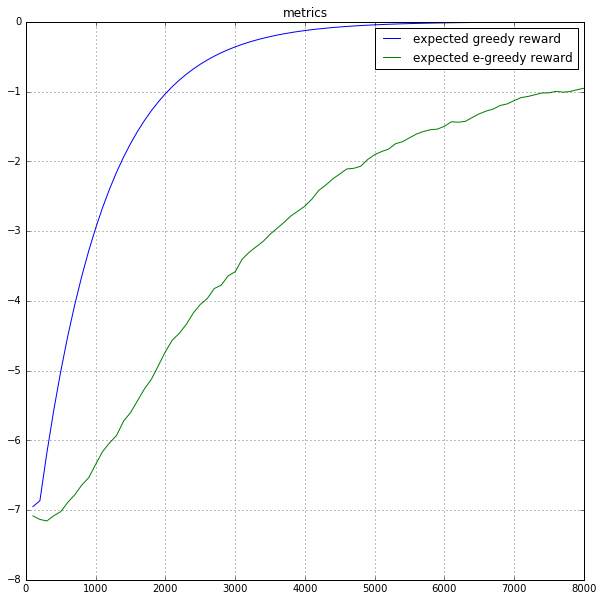

Random session examples
session # 0
 Origin:san(qv = -1.79643285275) -> -1.0(ref = -2.85249996185) |  Genres:avant-garde(qv = -1.61221706867) -> -1.0(ref = -1.95000004768) |  first_activity:1959(qv = -1.4898378849) -> -1.0(ref = -1.0) |  end_session_now(qv = -0.0135497730225) -> 0.0(ref = 0.0) | 

session # 1
 Origin:canada(qv = -1.68897151947) -> -1.0(ref = -1.0) |  end_session_now(qv = -0.0231476705521) -> 0.0(ref = 0.0) | 

session # 2
 end_session_now(qv = -0.0100269969553) -> 0.0(ref = 0.0) | 

epoch 8100,loss 0.52173, epsilon 0.47262, rewards: ( e-greedy -0.93136, greedy -0.00167) 
rec 0.280 reg 0.242
epoch 8200,loss 0.74872, epsilon 0.46841, rewards: ( e-greedy -0.90622, greedy -0.00150) 
rec 0.507 reg 0.242
epoch 8300,loss 2.16492, epsilon 0.46425, rewards: ( e-greedy -0.93960, greedy -0.00135) 
rec 1.924 reg 0.241
epoch 8400,loss 0.75550, epsilon 0.46012, rewards: ( e-greedy -0.93064, greedy -0.00122) 
rec 0.515 reg 0.241
epoch 8500,loss 1.04352, epsilon 0.45604, rewards: ( e-

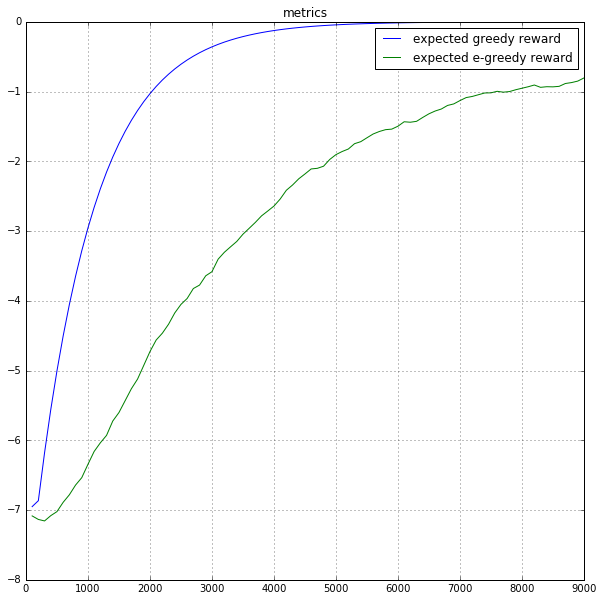

Random session examples
session # 0
 Origin:kingston(qv = -1.68789362907) -> -1.0(ref = -1.95000004768) |  Instruments:organ(qv = -1.34054660797) -> -1.0(ref = -1.0) |  end_session_now(qv = -0.00891516543925) -> 0.0(ref = 0.0) | 

session # 1
 decades_active:1990(qv = -0.453858911991) -> 1.0(ref = 1.0) |  end_session_now(qv = 0.0045761000365) -> 0.0(ref = 0.0) | 

session # 2
 end_session_now(qv = -0.00475582666695) -> 0.0(ref = 0.0) | 

epoch 9100,loss 1.79488, epsilon 0.43240, rewards: ( e-greedy -0.80264, greedy -0.00058) 
rec 1.557 reg 0.237
epoch 9200,loss 2.32391, epsilon 0.42859, rewards: ( e-greedy -0.80338, greedy -0.00052) 
rec 2.087 reg 0.237
epoch 9300,loss 0.35973, epsilon 0.42483, rewards: ( e-greedy -0.76904, greedy -0.00047) 
rec 0.123 reg 0.237
epoch 9400,loss 1.06534, epsilon 0.42110, rewards: ( e-greedy -0.76414, greedy -0.00042) 
rec 0.829 reg 0.236
epoch 9500,loss 0.41570, epsilon 0.41740, rewards: ( e-greedy -0.74772, greedy -0.00038) 
rec 0.180 reg 0.236
epoch 96

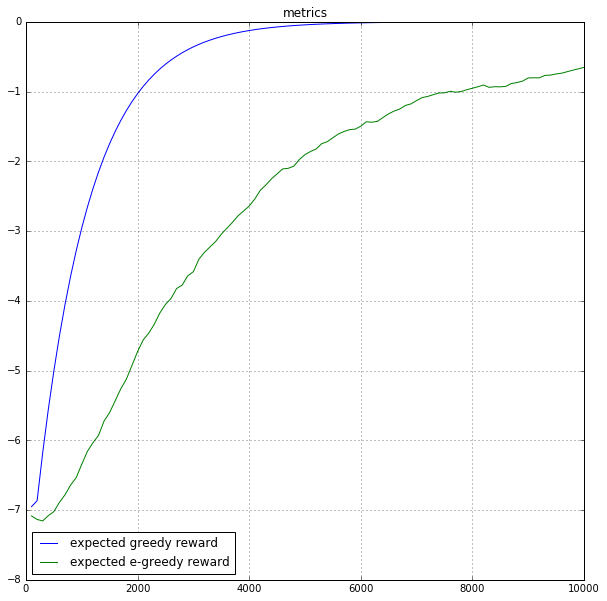

Random session examples
session # 0
 Genres:electropop(qv = -1.41686117649) -> -1.0(ref = -3.70987486839) |  first_activity:1995(qv = -1.22173309326) -> -1.0(ref = -2.85249996185) |  category:List_of_Swedes_in_music(qv = -1.34429061413) -> -1.0(ref = -1.95000004768) |  Instruments:piano(qv = -0.780086159706) -> -1.0(ref = -1.0) |  end_session_now(qv = -0.00680763088167) -> 0.0(ref = 0.0) | 

session # 1
 Origin:florida(qv = -1.51627600193) -> -1.0(ref = -2.85249996185) |  last_activity:2007(qv = -1.53168869019) -> -1.0(ref = -1.95000004768) |  Genres:dancehall(qv = -1.11548936367) -> -1.0(ref = -1.0) |  end_session_now(qv = 0.0212691966444) -> 0.0(ref = 0.0) | 

session # 2
 Occupation:and(qv = -1.42150557041) -> -1.0(ref = -1.0) |  end_session_now(qv = 0.00639242120087) -> 0.0(ref = 0.0) | 

saved /home/jheuristic/yozhik/agentnet_snapshots/research.rl_comparison.naive.epoch10000.pcl
epoch 10100,loss 1.15380, epsilon 0.39601, rewards: ( e-greedy -0.62763, greedy -0.00020) 
rec 0.921 re

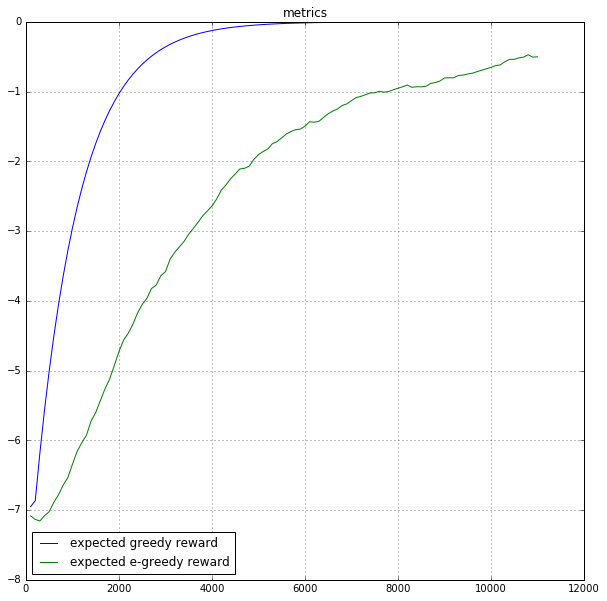

Random session examples
session # 0
 Occupation:tv(qv = -1.36846005917) -> -1.0(ref = -0.00487500429153) |  decades_active:2000(qv = 0.202444016933) -> 1.0(ref = 1.04750001431) |  decades_active:2010(qv = 0.101267628372) -> 1.0(ref = 0.0500000119209) |  Genres:progressive(qv = -1.06948590279) -> -1.0(ref = -1.0) |  end_session_now(qv = 0.0163515619934) -> 0.0(ref = 0.0) | 

session # 1
 end_session_now(qv = -0.00276539474726) -> 0.0(ref = 0.0) | 

session # 2
 end_session_now(qv = -0.00276540964842) -> 0.0(ref = 0.0) | 

epoch 11100,loss 1.16190, epsilon 0.36308, rewards: ( e-greedy -0.46870, greedy -0.00007) 
rec 0.933 reg 0.228
epoch 11200,loss 1.34604, epsilon 0.35997, rewards: ( e-greedy -0.45383, greedy 0.14194) 
rec 1.118 reg 0.228
epoch 11300,loss 1.44836, epsilon 0.35688, rewards: ( e-greedy -0.40744, greedy 0.29674) 
rec 1.221 reg 0.228
epoch 11400,loss 1.56354, epsilon 0.35383, rewards: ( e-greedy -0.38670, greedy 0.37907) 
rec 1.336 reg 0.227
epoch 11500,loss 1.43376, epsilo

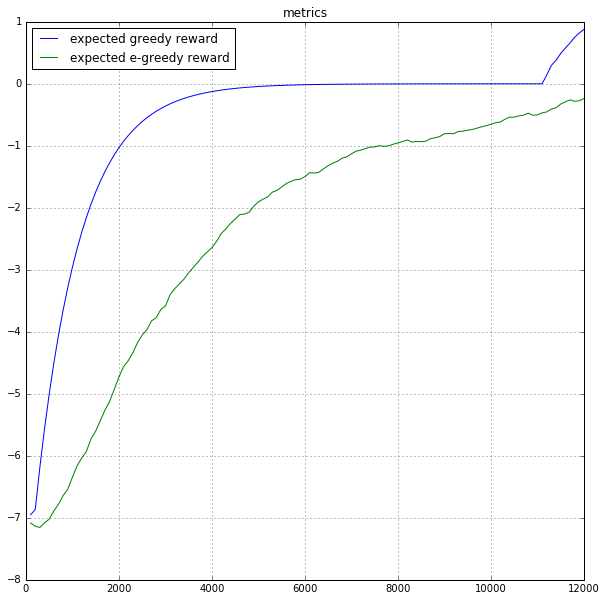

Random session examples
session # 0
 decades_active:2000(qv = 0.368154019117) -> 1.0(ref = 1.95000004768) |  decades_active:2010(qv = 0.232765376568) -> 1.0(ref = 1.0) |  end_session_now(qv = -0.00962131097913) -> 0.0(ref = 0.0) | 

session # 1
 Origin:sweden(qv = -1.19099652767) -> -1.0(ref = -2.85249996185) |  decades_active:2000(qv = 0.359498858452) -> -1.0(ref = -1.95000004768) |  category:List_of_alternative_country_musicians(qv = -1.2082529068) -> -1.0(ref = -1.0) |  end_session_now(qv = -0.0271164663136) -> 0.0(ref = 0.0) | 

session # 2
 decades_active:2000(qv = 0.368154078722) -> 1.0(ref = 1.95000004768) |  decades_active:2010(qv = 0.23276540637) -> 1.0(ref = 1.0) |  end_session_now(qv = -0.00962136313319) -> 0.0(ref = 0.0) | 

epoch 12100,loss 1.56602, epsilon 0.33329, rewards: ( e-greedy -0.19601, greedy 0.93174) 
rec 1.342 reg 0.224
epoch 12200,loss 1.50027, epsilon 0.33047, rewards: ( e-greedy -0.12041, greedy 0.99857) 
rec 1.277 reg 0.224
epoch 12300,loss 1.47943, epsilon

In [ ]:
n_epochs = 250000
batch_size= 50

for i in range(n_epochs):    
    
    #train
    env.load_random_batch(train_attrs,train_cats,batch_size)
    loss,avg_reward = train_fun()
    
    
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    if epoch_counter%10 ==0:
        current_epsilon =  0.05 + 0.95*np.exp(-epoch_counter/10000.)
        resolver.epsilon.set_value(np.float32(current_epsilon))
    
    
    
    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:

        ##update learning curves
        full_loss, q_loss, l2_penalty, avg_reward_current = evaluation_fun()
        ma_reward_current = (1-alpha)*ma_reward_current + alpha*avg_reward_current
        score_log["expected e-greedy reward"][epoch_counter] = ma_reward_current
        
        
        
        #greedy train
        resolver.epsilon.set_value(0)
        avg_reward_greedy = evaluation_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["expected greedy reward"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        resolver.epsilon.set_value(np.float32(current_epsilon))

        print "epoch %i,loss %.5f, epsilon %.5f, rewards: ( e-greedy %.5f, greedy %.5f) "%(
            epoch_counter,full_loss,current_epsilon,ma_reward_current,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,l2_penalty)

    if epoch_counter %1000 ==0:
        print "Learning curves:"
        score_log.plot()


        print "Random session examples"
        env.load_random_batch(train_attrs,train_cats,3)
        display_sessions(with_plots=False)
    
    #save snapshot
    if epoch_counter %10000 ==0:
        snap_name = "{}.epoch{}.pcl".format(os.path.join(snapshot_path,experiment_setup_name), epoch_counter)
        save(resolver,snap_name)
        print "saved", snap_name

        
        
    epoch_counter  +=1

    
# Time to drink some coffee!

# Evaluating results

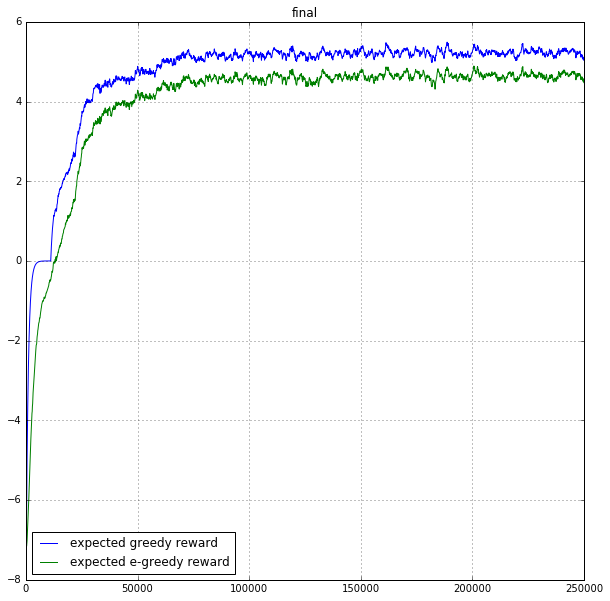

In [34]:
score_log.plot("final")

Random session examples
session # 0
 decades_active:2000(qv = 3.94235873222) -> 1.0(ref = 3.8659992218) |  Occupation:lyricist(qv = 2.25702261925) -> -1.0(ref = 3.01684141159) |  Labels:is_known(qv = 3.40171957016) -> 1.0(ref = 4.22825431824) |  decades_active:2010(qv = 3.06541967392) -> 1.0(ref = 3.39816212654) |  Birth name:is_known(qv = 2.31213641167) -> -1.0(ref = 2.52438116074) |  last_activity:still_active(qv = 2.22503662109) -> 1.0(ref = 3.70987486839) |  decades_active:1990(qv = 1.42132663727) -> 1.0(ref = 2.85249996185) |  Website:is_known(qv = 0.548826515675) -> 1.0(ref = 1.95000004768) |  decades_active:1980(qv = 0.292955577374) -> 1.0(ref = 1.0) |  end_session_now(qv = 1.66986137629e-05) -> 0.0(ref = 0.0) | reached max session length


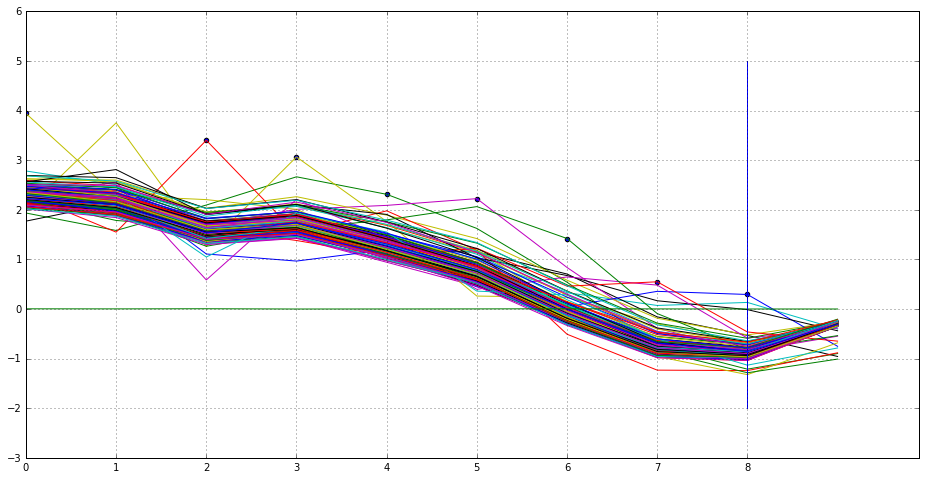

session # 1
 decades_active:2000(qv = 3.94235873222) -> 1.0(ref = 5.33491659164) |  decades_active:2010(qv = 3.75362801552) -> 1.0(ref = 4.56307029724) |  Labels:is_known(qv = 3.00276470184) -> 1.0(ref = 3.75060033798) |  Birth name:is_known(qv = 2.52854633331) -> 1.0(ref = 2.89536881447) |  last_activity:still_active(qv = 2.11774396896) -> 1.0(ref = 1.99512505531) |  decades_active:1990(qv = 1.43652772903) -> 1.0(ref = 1.04750001431) |  Website:is_known(qv = 0.965214967728) -> 1.0(ref = 0.0500000119209) |  category:List_of_Indian_playback_singers(qv = -0.822768747807) -> -1.0(ref = -1.0) |  end_session_now(qv = -0.00028464384377) -> 0.0(ref = 0.0) | 



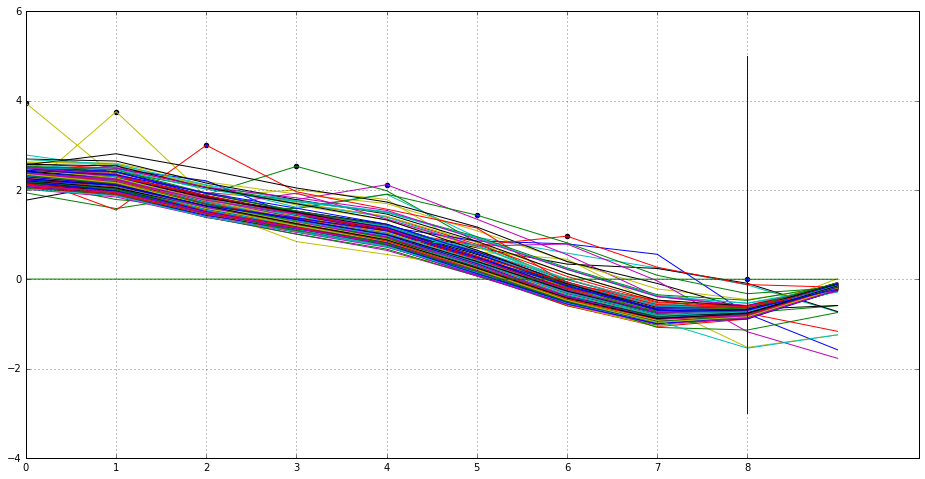

session # 2
 decades_active:2000(qv = 3.94235801697) -> 1.0(ref = 4.26317119598) |  decades_active:2010(qv = 3.75362801552) -> 1.0(ref = 3.4349167347) |  Labels:is_known(qv = 3.00276494026) -> -1.0(ref = 2.56307029724) |  Birth name:is_known(qv = 2.8970272541) -> 1.0(ref = 3.75060033798) |  last_activity:still_active(qv = 2.52633619308) -> 1.0(ref = 2.89536881447) |  decades_active:1990(qv = 2.1574985981) -> 1.0(ref = 1.99512505531) |  decades_active:1980(qv = 1.47723007202) -> 1.0(ref = 1.04750001431) |  Instruments:guitar(qv = 0.670756876469) -> 1.0(ref = 0.0500000119209) |  decades_active:1970(qv = 0.102770678699) -> -1.0(ref = -1.0) |  end_session_now(qv = -0.000328509137034) -> 0.0(ref = 0.0) | reached max session length


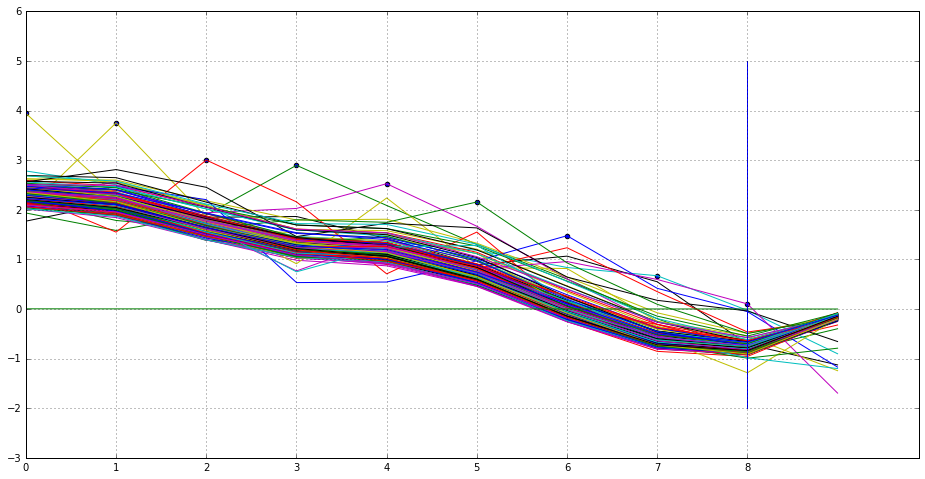

session # 3
 decades_active:2000(qv = 3.94235873222) -> 1.0(ref = 7.39501094818) |  decades_active:2010(qv = 3.75362801552) -> 1.0(ref = 6.73159074783) |  Labels:is_known(qv = 3.00276470184) -> 1.0(ref = 6.03325366974) |  Birth name:is_known(qv = 2.52854633331) -> 1.0(ref = 5.29816198349) |  last_activity:still_active(qv = 2.11774396896) -> 1.0(ref = 4.52438116074) |  decades_active:1990(qv = 1.43652772903) -> 1.0(ref = 3.70987486839) |  Website:is_known(qv = 0.965214967728) -> 1.0(ref = 2.85249996185) |  decades_active:1980(qv = 0.559262931347) -> 1.0(ref = 1.95000004768) |  Instruments:vocals(qv = 0.123287178576) -> 1.0(ref = 1.0) |  end_session_now(qv = 6.28679990768e-05) -> 0.0(ref = 0.0) | reached max session length


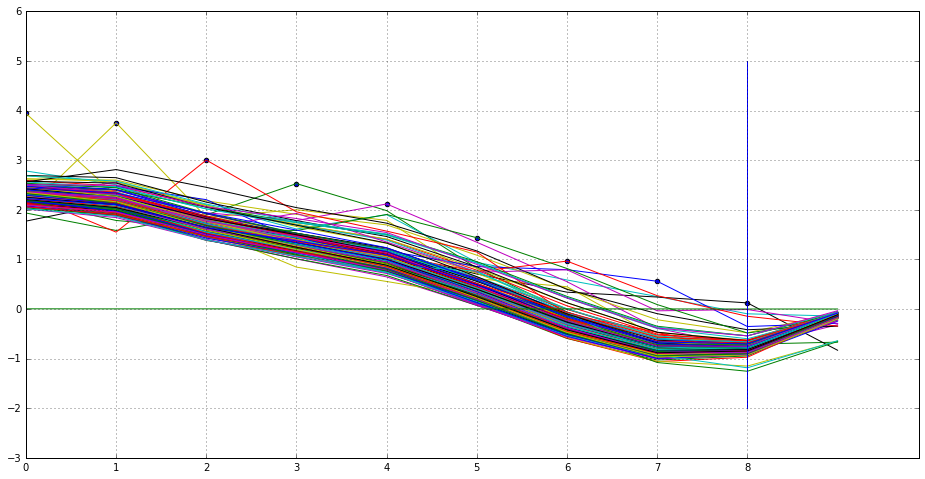

session # 4
 decades_active:2000(qv = 3.94235873222) -> 1.0(ref = 7.39501094818) |  decades_active:2010(qv = 3.75362801552) -> 1.0(ref = 6.73159074783) |  Labels:is_known(qv = 3.00276470184) -> 1.0(ref = 6.03325366974) |  Birth name:is_known(qv = 2.52854633331) -> 1.0(ref = 5.29816198349) |  last_activity:still_active(qv = 2.11774396896) -> 1.0(ref = 4.52438116074) |  decades_active:1990(qv = 1.43652772903) -> 1.0(ref = 3.70987486839) |  Website:is_known(qv = 0.965214967728) -> 1.0(ref = 2.85249996185) |  decades_active:1980(qv = 0.559262931347) -> 1.0(ref = 1.95000004768) |  Instruments:vocals(qv = 0.123287178576) -> 1.0(ref = 1.0) |  end_session_now(qv = 6.28679990768e-05) -> 0.0(ref = 0.0) | reached max session length


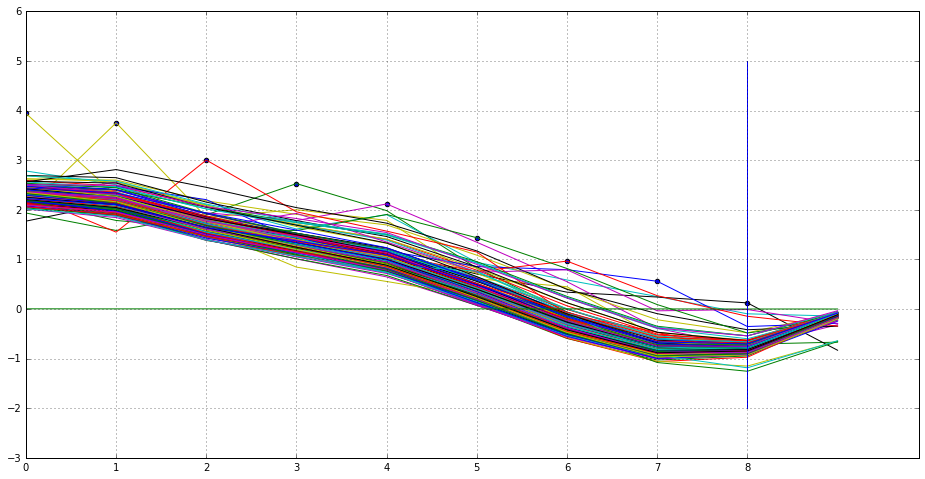

session # 5
 decades_active:2000(qv = 3.94235873222) -> 1.0(ref = 3.62016701698) |  decades_active:2010(qv = 3.75362801552) -> 1.0(ref = 2.7580704689) |  Labels:is_known(qv = 3.00276470184) -> 1.0(ref = 1.85060036182) |  Birth name:is_known(qv = 2.52854633331) -> -1.0(ref = 0.895368814468) |  last_activity:still_active(qv = 2.55402112007) -> 1.0(ref = 1.99512505531) |  decades_active:1990(qv = 1.77221333981) -> 1.0(ref = 1.04750001431) |  Website:is_known(qv = 0.898242533207) -> 1.0(ref = 0.0500000119209) |  Agent:is_known(qv = -1.005387187) -> -1.0(ref = -1.0) |  end_session_now(qv = -0.000152638182044) -> 0.0(ref = 0.0) | 



In [ ]:
print "Random session examples"
env.load_random_batch(train_attrs,train_cats,10)
display_sessions(with_plots=True)
